In [5]:
import numpy as np
from celmech.maps import CometMap
import sys
sys.path.append("../code/")
from sos_utils import get_map_pts
from matplotlib import pyplot as plt

In [150]:
from scipy.optimize import root_scalar

def symmetry_line1(s):
    return np.array((0,s))
def symmetry_line2(s):
    return np.array((np.pi,s))
def symmetry_line3(s):
    return np.array((np.pi * s ,s))

def nest_map(pt0,cmap,n):
    for _ in range(n):
        pt0 = cmap(pt0)
    return pt0

def nest_map_list(pt0,cmap,n):
    pts = np.zeros((n,2))
    for i in range(n):
        pts[i] = pt0
        pt0 = cmap(pt0)
    return pts
    
def find_periodic_orbit(m,n,cmap,guess=None,minimax=False,atol=1e-10):
    
    cmap.mod = False

    if minimax:
        symline = symmetry_line1
    else:
        symline = symmetry_line2 if n%2 else symmetry_line3
    rootfn = lambda s: nest_map(symline(s),cmap,n)[0] - symline(s)[0] - 2 * np.pi * m
    
    xmin = (m-1) / n
    x0  =  m  / n
    xmax = (m+1) / n
    if guess is None:
        guess = x0
        
    x1 = xmin + 0.5*(guess - xmin)
    rt = root_scalar(rootfn,x0=guess,x1 = x1,xtol=atol)
    assert rt.converged,"Root-finding failed for ({},{})".format(m,n)
    pt0 = symline(rt.root)    
    orbit = nest_map_list(pt0,cmap,n)
    
    return orbit

def get_H_matrix(orbit,cmap):
    N = len(orbit)
    off_diag = np.ones(N-1)
    H = 2 * np.eye(N) - np.diag(off_diag,-1) - np.diag(off_diag,+1)
    thetas = orbit[:,0]
    H = H + cmap.K * np.diag(np.cos(thetas))
    H[N-1,0]=-1
    H[0,N-1]=-1
    return H
def get_M_matrix(orbit,cmap):
    M = np.eye(2)
    for pt in orbit:
        M = np.matmul(cmap.jac(pt) , M)
    return M

In [145]:
import sympy as sp
from sympy.ntheory import continued_fraction, continued_fraction_convergents


In [154]:
cmap = CometMap(3.15e-5,6,40/30)
m,n = convergents[-2]
orbit=find_periodic_orbit(m,n,cmap)
orbit[0] - (cmap(orbit[-1])  - np.array([2*np.pi*m,0]))

array([-5.60218538e-13,  2.16493490e-15])

In [186]:
convergents[-3:]

[(34, 89), (55, 144), (89, 233)]

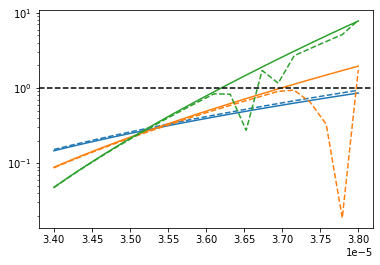

In [196]:
for m,n in convergents[-4:-1]:
    guess_mm = None
    guess_min= None
    Neps = 20
    eps_vals = np.linspace(3.4e-5,3.8e-5,Neps)
    Rvals,fvals = np.zeros((2,Neps,2))

    for i,eps in enumerate(eps_vals):
        cmap.m = eps
        minimax_orbit = find_periodic_orbit(m,n,cmap,minimax=True,guess=guess_mm)
        minimizing_orbit = find_periodic_orbit(m,n,cmap,guess=guess_min)

        gues_mm = minimax_orbit[0,1]
        gues_min = minimax_orbit[0,1]

        M = get_M_matrix(minimax_orbit,cmap)
        R = 0.25 * (2 - np.trace(M))
        f = (np.abs(R)/0.25)**(1/n)
        Rvals[i,0] = R
        fvals[i,0] = f

        M = get_M_matrix(minimizing_orbit,cmap)
        R = 0.25 * (2 - np.trace(M))
        f = (np.abs(R)/0.25)**(1/n)
        Rvals[i,1] = R
        fvals[i,1] = f
    l,=plt.plot(eps_vals,np.abs(Rvals[:,0]))
    plt.plot(eps_vals,np.abs(Rvals[:,1]),'--',color=l.get_color())
plt.yscale('log')
plt.axhline(1,color='k',ls='--')

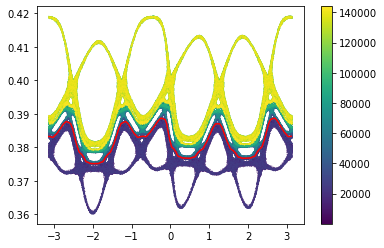

In [237]:
cmap.m = 3.8e-5
orbit = find_periodic_orbit(m,n,cmap,minimax=True,guess=None)
th,p=np.transpose(get_map_pts(orbit[0],cmap,n))
th = wrap2pi(th)
p = wrap1(p)
iorder = np.argsort(th)
plt.plot(th[iorder],p[iorder],'r-',zorder=99)

# plt.ylim(np.min(p),np.max(p))

th,p=np.transpose(get_map_pts(orbit[0] + np.array([0,1e-8]),cmap,1000*n))
th = wrap2pi(th)
p = wrap1(p)
plt.scatter(th,p,s=0.1,c=1+np.arange(1000*n),cmap='viridis')
plt.colorbar()

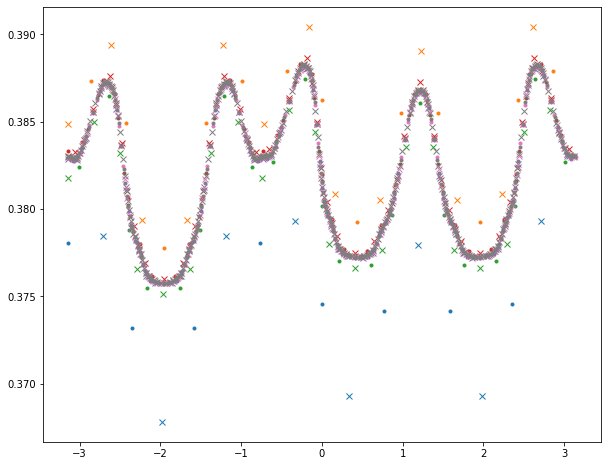

In [168]:
# wrap1 = lambda x: np.mod(x+0.5,1)-0.5
# wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
# for sline in [symmetry_line1,symmetry_line2,symmetry_line3]:
#     theta,w = np.transpose([sline(s) for s in np.linspace(-0.5,0.5)])
#     plt.plot(wrap2pi(theta),wrap1(w),'k-',lw=2)
                           
# pt0s = np.array([(0,x) for x in np.random.normal(0,1e-5,size=50)])
# for pt0 in pt0s:
#     th,p = np.transpose(get_map_pts(pt0,cmap,500))
#     plt.plot(wrap2pi(th),wrap1(p),'.',ms=0.5)


cmap = CometMap(3.5e-5,6,40/30)
plt.figure(figsize =(10,8))
cf = continued_fraction_convergents([0,2] + [1 for _ in range(10)])
convergents = [(f.numerator,f.denominator) for f in cf][4:]
Rvals = np.zeros((len(convergents),2))
fvals = np.zeros((len(convergents),2))

for i,convergent in enumerate(convergents):
    
    m,n = convergent
    
    minimax_orbit = find_periodic_orbit(m,n,cmap,minimax=True)
    minimizing_orbit = find_periodic_orbit(m,n,cmap)

    theta,p = np.transpose(minimax_orbit)
    theta = wrap2pi(theta)
    l,=plt.plot(theta,p,'.')

    theta,p = np.transpose(minimizing_orbit)
    theta = wrap2pi(theta)
    plt.plot(theta,p,'x',color=l.get_color())
    
    M = get_M_matrix(minimax_orbit,cmap)
    R = 0.25 * (2 - np.trace(M))
    f = (np.abs(R)/0.25)**(1/n)
    Rvals[i,0] = R
    fvals[i,0] = f

    M = get_M_matrix(minimizing_orbit,cmap)
    R = 0.25 * (2 - np.trace(M))
    f = (np.abs(R)/0.25)**(1/n)
    Rvals[i,1] = R
    fvals[i,1] = f
# th,p=np.transpose(get_map_pts((-1,0.3875),cmap,10000))
# th = wrap2pi(th)
# p = wrap1(p)
# plt.plot(th,p,'k.',ms=0.5)


In [327]:
def get_exit_time(pt0,cmap,wlow,whigh,Nmax):
    orbit = np.zeros((Nmax,2))
    for i in range(Nmax):
        orbit[i] = pt0
        pt0 = cmap(pt0)
        w = pt0[1]
        if w<wlow or w>whigh:
            return i,orbit[:i]
    else:
        return np.inf,orbit

def get_exit_time_no_orbit(pt0,cmap,wlow,whigh,Nmax):
    for i in range(Nmax):
        pt0 = cmap(pt0)
        w = pt0[1]
        if w<wlow or w>whigh:
            return i
    else:
        return np.inf

In [325]:
from rebound.interruptible_pool import InterruptiblePool

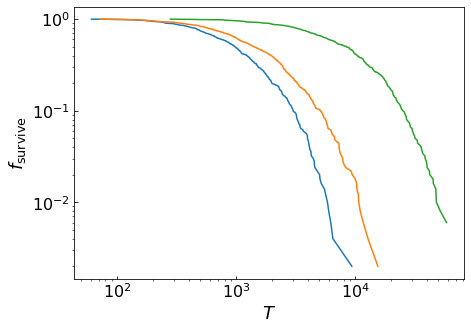

In [307]:
plt.figure(figsize=(7,5))


wrap1 = lambda x: np.mod(x,1)
cmap.m = 5.15e-5
cmap.mod = True
Npts = 500
Nmax = 1500*40
pts0 = [(np.pi,w) for w in np.random.normal(0.5,1e-6,Npts)]
Tesc_data = []
for N in range(20,17,-1):
    cmap.N = N
    times = np.zeros(Npts)
    for i,pt0 in enumerate(pts0):
        length,orbit = get_exit_time(pt0,cmap,0,1,Nmax)
        times[i] = length
        theta,w = np.transpose(orbit)
        w_mod = wrap1(w)
    times_s = np.sort(times)
    fsurvive = np.arange(Npts,0,-1) + np.isinf(times_s)
    fsurvive = fsurvive/Npts
    plt.plot(times_s,fsurvive)

plt.yscale('log')
plt.xscale('log')
plt.xlabel("$T$",fontsize=18)
plt.ylabel("$f_\mathrm{survive}$",fontsize=18)
plt.tick_params(direction='in',labelsize=16)


# Toy model

In [522]:
from scipy.special import erf,erfc
def diffusion_survival_function(t,nmax=4):
    f = 0
    for k in range(1,nmax+1):
        if k%2:
            f+=4 * np.sin(k * np.pi * 0.5) * np.exp( - 0.5 * k*k * np.pi * np.pi * t) / np.pi /k
    return f

(100, 27937.30409074496)

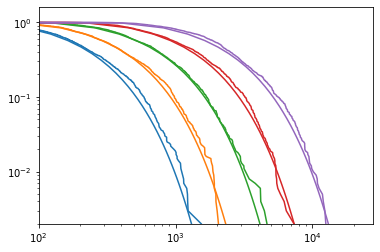

In [568]:
def get_simple_escape_time(D = 1, x = 0.5):
    i=0
    while 0<x<1:
        i += 1
        x += np.sqrt(D) * np.random.normal()
    return i

Npath = 1000
for Dtoy in np.geomspace(1e-3,1e-4,5):
    toy_times = np.array([0]  + [ get_simple_escape_time(Dtoy) for _ in range(Npath)])
    tesc = np.sort(toy_times)
    Nsurvive = np.arange(Npath,-1,-1)
    l,=plt.plot(tesc,Nsurvive/Npath)
    tplot = np.linspace(0,2/Dtoy)   
    plt.plot(tplot,diffusion_survival_function( Dtoy * tplot,nmax=64),color = l.get_color())
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymin = 2/Npath)
plt.xlim(xmin=100)

# map escape time distribution

(2e-05, 1)

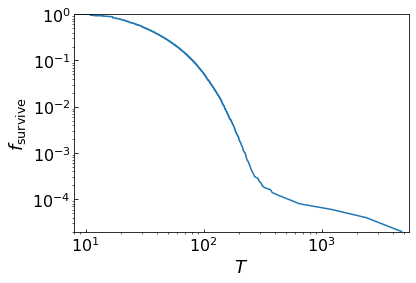

In [622]:
plt.plot(times_s,fsurvive)


plt.xlim(times_s[0],np.max(times_s))
plt.ylim(1/Npts,1)

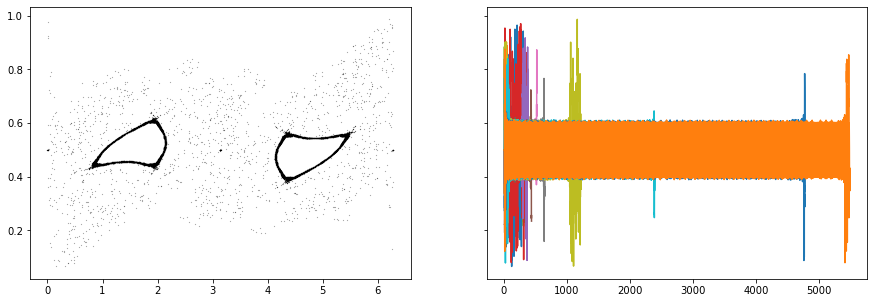

In [628]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(15,5))
for t in times_s[times_s>0.3e3]:
    i0 = np.argmin(np.abs(times - t))
    orbit = get_map_pts(pts0[i0],cmap,times[i0])
    theta,w =np.transpose(orbit)
    ax[0].plot(theta,w,'k.',ms=0.25)
    ax[1].plot(w)

In [681]:
#plt.figure(figsize=(7,5))


wrap1 = lambda x: np.mod(x,1)
cmap.m = 5.15e-5

cmap.mod = True
Npts = 50_000
Nmax = 50_000


pts0 = [(np.pi,w) for w in np.random.normal(0.5,1e-6,Npts)]

fit_func = lambda x,tau: diffusion_survival_function(x/tau,nmax=20)
all_times = []
for N in [50,40,30,25]:
    cmap.N = N
    def fn(pt0):
        return get_exit_time_no_orbit(pt0,cmap,0,1,Nmax)
    pool = InterruptiblePool()
    results = pool.map_async(fn,pts0)
    times = np.array(results.get())
    all_times.append(times)

In [736]:
more_times = []
for N in [90,80,70,60]:
    cmap.N = N
    def fn(pt0):
        return get_exit_time_no_orbit(pt0,cmap,-1,2,Nmax)
    pool = InterruptiblePool()
    results = pool.map_async(fn,pts0)
    times = np.array(results.get())
    more_times.append(times)

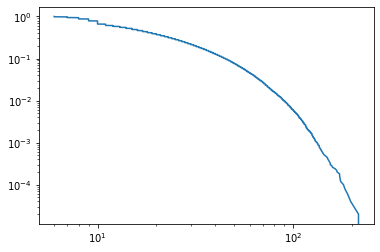

In [740]:
times = more_times[1]
times_s = np.sort(times)
fsurvive = np.arange(Npts-1,-1,-1) + np.isinf(times_s)
fsurvive = fsurvive/Npts
plt.loglog(times_s,fsurvive)

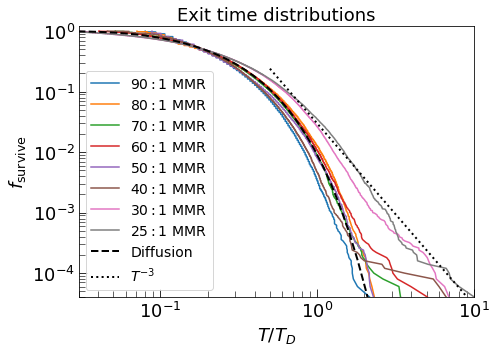

In [744]:
taus = []
tau_DQLs = []
plt.figure(figsize=(7,5))
Nvals = [90,80,70,60]  + [50,40,30,25]

for i,times in enumerate(more_times + all_times):
    
    cmap.N = Nvals[i]
    tau_DQLs.append(1/cmap.D_QL())
    times_s = np.sort(times)
    fsurvive = np.arange(Npts-1,-1,-1) + np.isinf(times_s)
    fsurvive = fsurvive/Npts
    msk = np.logical_and(fsurvive>0.05, fsurvive<0.9)
    
    fitresult = curve_fit(fit_func,times_s[msk],fsurvive[msk],p0=1/DQL)
    tau_fit = fitresult[0]
    taus.append(tau_fit)
    
    
    tplot = np.geomspace(np.min(times_s),np.max(times_s[times_s<np.inf]))
    l,=plt.plot(times_s/tau_fit,fsurvive,label=r"${}:1$ MMR".format(Nvals[i]))
plt.plot(np.geomspace(1e-2,5),fit_func(np.geomspace(1e-2,5),1),ls='--',color='k',lw=2,label=r"Diffusion")
plt.plot(np.geomspace(0.5,10),3e-2*np.geomspace(0.5,10)**(-3),'k:',lw=2,label=r"$T^{-3}$")
plt.yscale('log')
plt.xscale('log')
plt.xlim(3e-2,10)
plt.ylim(ymin = 2/Nmax,ymax=1.2)
plt.xlabel("$T/T_D$",fontsize=18)
plt.ylabel("$f_\mathrm{survive}$",fontsize=18)
plt.tick_params(direction='in',labelsize=18,size=8)
plt.tick_params(direction='in',size=6,which='minor')
plt.legend(loc='lower left',fontsize=14)
plt.title("Exit time distributions",fontsize=18)
plt.tight_layout()
plt.savefig("../figures/exit_time_dists.png")

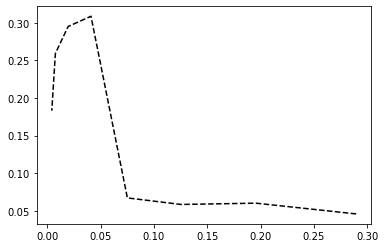

In [878]:
plt.plot(1/np.array(tau_DQLs),np.array(tau_DQLs)/np.array(taus).reshape(-1),'k--')


array([  75.08470063,   84.82848049,  136.28114242,  198.33596514,
         79.3309555 ,  174.60553863,  518.18040764, 1347.17336267])

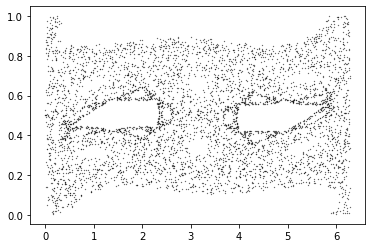

In [752]:
orbit = get_map_pts(pt0,cmap,5000)
theta,w = np.transpose(orbit)
plt.plot(theta,wrap1(w),'k.',ms=0.5)

In [770]:
a @ a

24.469043971418635

In [771]:
a[1:] @ a[:-1]

-0.5301510981787595

In [774]:
np.correlate(a,a,mode='full')[1]

1.2058313845748938e-06

In [775]:
?np.correlate

In [908]:
a1 = np.array([1, 2, 3, 4,5,6])

L = len(a1)
for k in range(L):
    tot = 0
    for l in range(L-k):
        tot += a1[l]*a1[l+k]
    print(k,tot)

C = np.correlate(a1,a1, "full")[L-1:] * (1/(L - np.arange(L)))
C

0 91
1 70
2 50
3 32
4 17
5 6


array([15.16666667, 14.        , 12.5       , 10.66666667,  8.5       ,
        6.        ])

In [910]:
np.mean(a1 * a1) 

15.166666666666666

In [863]:
Nvals

[90, 80, 70, 60, 50, 40, 30, 25]

In [881]:
a_array.shape

(50, 1000)

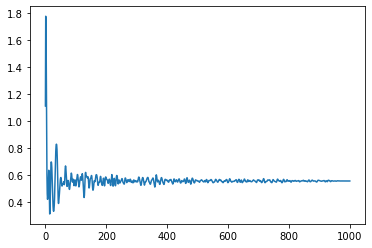

In [889]:
plt.plot(np.cumsum(Ck))

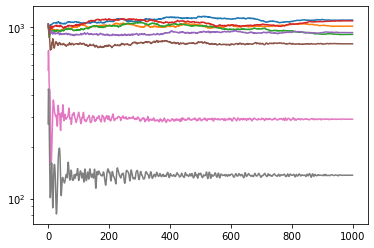

In [890]:
M = 50
L = 1000
for N in Nvals:
    cmap.N = N
    a_array = np.zeros((M,L))
    pts0 = np.array([(np.pi,w) for w in np.random.normal(0,1e-6,size=M)])
    new_pts0 = []
    for i,pt0 in enumerate(pts0):
        orbit = get_map_pts(pt0,cmap,L+1)
        theta,w = np.transpose(orbit)
        a = np.convolve([1,-1],w,mode='valid')
        a_array[i] = a
        new_pts0.append(orbit[-1])
    Ck =np.mean(np.array([np.correlate(a_array[i],a_array[i],mode='full')[L-1:] for i in range(M)]),axis=0)
    #plt.plot(Ck,'ks-')
    DQL =cmap.D_QL()
    l,=plt.plot(np.cumsum(Ck)/DQL,'-')
plt.yscale('log')